X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)
Loaded 400000 word vectors.
Epoch 1/10
37/37 [==============================] - 17s 448ms/step - loss: 0.8467 - acc: 0.6332 - val_loss: 0.7627 - val_acc: 0.6867
Epoch 2/10
37/37 [==============================] - 17s 462ms/step - loss: 0.7125 - acc: 0.7125 - val_loss: 0.6451 - val_acc: 0.7452
Epoch 3/10
37/37 [==============================] - 18s 483ms/step - loss: 0.6405 - acc: 0.7397 - val_loss: 0.6181 - val_acc: 0.7554
Epoch 4/10
37/37 [==============================] - 18s 483ms/step - loss: 0.6215 - acc: 0.7437 - val_loss: 0.5986 - val_acc: 0.7610
Epoch 5/10
37/37 [==============================] - 18s 485ms/step - loss: 0.5919 - acc: 0.7593 - val_loss: 0.5825 - val_acc: 0.7636
Epoch 6/10
37/37 [==============================] - 18s 482ms/step - loss: 0.5825 - acc: 0.7627 - val_loss: 0.5653 - val_acc: 0.7772
Epoch 7/10
37/37 [==============================] - 18s 482ms/step - loss: 0

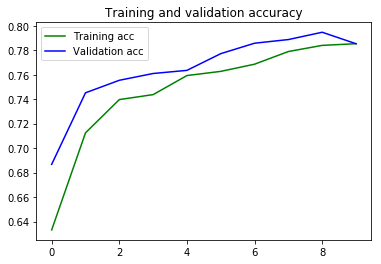

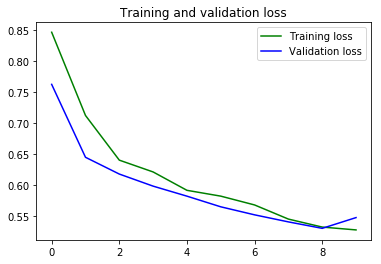

Confusion matrix, without normalization
[[1655  165   50]
 [ 241  321   52]
 [  94   53  297]]
Normalized confusion matrix
[[0.89 0.09 0.03]
 [0.39 0.52 0.08]
 [0.21 0.12 0.67]]


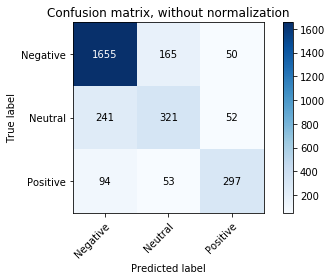

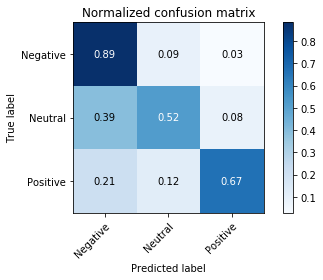

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline
df= pd.read_csv('C:/Users/Sikonic-Admin/data/Tweets.csv', sep=',')

# Count number of each type of tweet
df['airline_sentiment'].value_counts()

# Convert to integers values
df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', 1)
df['airline_sentiment'] = df['airline_sentiment'].replace('negative', 0)
df['airline_sentiment'] = df['airline_sentiment'].replace('positive', 2)

# Split into text and label
X = df['text'] # data
y = df['airline_sentiment'] # labels

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1
# integer encode everything
sequences = t.texts_to_sequences(X)

# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length
tweet_num = max_tweet()
tweet_num

# each review has a different number of words, so pad sequence with 0's
# https://realpython.com/python-keras-text-classification/
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

# Convert labels
labels = to_categorical(np.asarray(y))

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

# load the whole embedding into memory
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('C:/Users/Sikonic-Admin/data/glove.6B.100d.txt',encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix
        
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=10, batch_size=256)

# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Get predicted values
y_pred = lstm_mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

class_names = np.array(['Negative', 'Neutral', 'Positive'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


